In [13]:

from __future__ import division, print_function
from astropy.table import Table
from matplotlib import pyplot as plt
import numpy as np
import ebf
import os

In [2]:
def unbound_only():
    # remove bound sat stars
    satprop = ebf.read('./satprop.ebf')
    for table_fh in [f for f in os.listdir(os.path.curdir) if f.endswith('.hdf5')]:
        #print table_fh
        table = Table.read(table_fh, format='hdf5', path='data')
        #print len(table)
        for satid in range(int(table.meta['satid_start']), int(table.meta['satid_end'])):
            if satprop['bsat'][satid]:
                #print ' --> ', satid
                remove = np.nonzero(table['satids'] == satid)
                #print ' --> ', len(remove)
                table.remove_rows(remove)
        #print len(table)        
        table.write(table_fh, format='hdf5', path='data', overwrite=True)

In [4]:
halo_table = Table.read('./halo08_4.0Mpc_h158_table.hdf5', path='data')
for key in halo_table.meta.keys():
    print key, halo_table.meta[key]

halo halo08
abm_lim -0.89
m_lims ['29.0', '28.0', '27.0']
d_mpc 4.0
f_type h158
sat0 416
sat1 574
n_sats 157
spinbin_output_fh C:\Users\swc21\skysurvey\tables\spinbin_output\halo08_4.0Mpc_h158_table.hdf5


In [37]:
for i in range(1, 10, 1):
    print(i, 600.0 * kpc_to_arcmin(i), 600 * kpc_to_arcsec(i))

1 2.06264806247 123.758883748
2 1.03132403124 61.8794418741
3 0.687549354157 41.2529612494
4 0.515662015618 30.9397209371
5 0.412529612494 24.7517767497
6 0.343774677078 20.6264806247
7 0.294664008924 17.6798405355
8 0.257831007809 15.4698604685
9 0.229183118052 13.7509870831


In [89]:
def kpc_to_arcmin(d_mpc):
    d = 1.0
    D = d_mpc * 1e6
    arcmin_mod = (60.0 * 180.0) / np.pi
    return arcmin_mod * (d / D)

def kpc_to_arcsec(d_mpc):
    d = 1.0
    D = d_mpc * 1e6
    arcsec_mod = 206264.80624709636 #(3600.0 * 180.0) / np.pi
    return arcsec_mod * (d / D)

def fix_rslice(grid, d_mpc=4.0, unit='kpc', rslices=[4]):
    '''
    helper function for plot_halo()

    fills the entire grid slice for radius
    this is needed for a smooth contour over plot

    Arguments:
        grid {np.ndarray} -- the grid

    Keyword Arguments:
        rslices {list} -- slice with radius for all stars (default: {[14]})

    Returns:
        np.ndarray -- the same grid but with filled radial slice
    '''
    # TODO - determine the ratio
    # ratio = (2.0 * 300.0 / 600.0)

    # find center of grid
    x_center = (grid.shape[1] / 2)
    y_center = (grid.shape[0] / 2)
    
    # conver to arcmin
    if unit == 'arcmin':
        ratio = kpc_to_arcmin(d_mpc)
    elif unit == 'arcsec':
        ratio = kpc_to_arcsec(d_mpc)
    else:
        ratio = 1
    # iterate over whole grid one by one
    for r in rslices:
        for i in range(grid.shape[0]):
            for q in range(grid.shape[1]):
                value = np.sqrt((
                    np.square(i - y_center) +
                    np.square(q - x_center))
                )
                
                if value > 300.0:
                    value = 0.0
                value *= ratio
                grid[i, q, r] = value

    return grid

In [95]:
plot_units = 'arcsec'
plot_radius_kpc = 150
distance = 4.0

In [91]:
[str(i) for i in np.linspace(-plot_radius_kpc, plot_radius_kpc, 7)]

['-150.0', '-100.0', '-50.0', '0.0', '50.0', '100.0', '150.0']

In [92]:
[str(round(i * kpc_to_arcsec(4.0), 2)) for i in np.linspace(-plot_radius_kpc, plot_radius_kpc, 7)]

['-7.73', '-5.16', '-2.58', '0.0', '2.58', '5.16', '7.73']

C:\Users\swc21\Anaconda2\lib\site-packages\ipykernel\__main__.py:28: RuntimeWarning: divide by zero encountered in log10


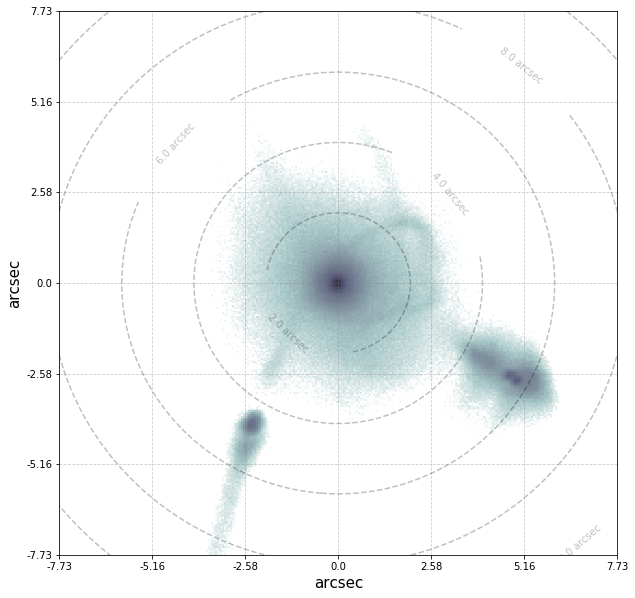

In [96]:
fig = plt.figure(figsize=(10, 10))

# make a single subplot
ax = fig.add_subplot(111)

# set titles & labels for axes & plot
ax.set_xlabel(plot_units, fontsize=15)
ax.set_ylabel(plot_units, fontsize=15)

# make & set tick labels for xy axes
# TODO - automaticly determin labels
if plot_units == 'kpc':

    _levels = None [50., 100., 150., 300.]
    clabel_frmt = '%s Kpc'
elif plot_units == 'arcmin':
    #ticks = [str(i) for i in np.linspace(-plot_radius_kpc, plot_radius_kpc, 7)]
    #ax.set_xticklabels(ticks, fontsize=10)
    #ax.set_yticklabels(ticks, fontsize=10)
    _levels = None#[50, 100, 150, 300]
    clabel_frmt = '%s arcmin'
elif plot_units == 'arcsec':
    clabel_frmt = '%s arcsec'
# fill radius grid slice for contour
grid = fix_rslice(np.load('../grids/halo08_4.0Mpc_h158_grid.npy'), d_mpc=distance, unit=plot_units)

# plot heat map
ax.pcolormesh(np.log10(grid[8:, :-3, 0]),
              cmap=plt.cm.bone_r,
              vmin=1.0,
              vmax=4.5)

# plot contour map to overlay on heat map
cp = ax.contour(grid[:, :, 4],
                levels=_levels,
                colors='k',
                linewidths=1.5,
                alpha=.25,
                linestyles='dashed')

# labels for contour overlay
cl = ax.clabel(cp,
               levels=_levels,
               inline=1,
               fmt=clabel_frmt,
               fontsize=10,
               color='k',
               linewidth=50,
               alpha=1)

# set plot xy limits
center = grid.shape[0] / 2
include = plot_radius_kpc
lim0 = center + include
lim1 = center - include
ax.set_xlim([lim1, lim0])
ax.set_ylim([lim1, lim0])

# set unit tick labels
current_ticks = ax.axes.get_xticks()
if plot_units == 'kpc':
    ticks = current_ticks - 300

elif plot_units == 'arcmin':
    ticks = ((current_ticks - 300) * kpc_to_arcmin(distance)).round(2)

elif plot_units == 'arcsec':
    ticks = ((current_ticks - 300) * kpc_to_arcsec(distance)).round(2)
    
ax.set_xticklabels(ticks, fontsize=10)
ax.set_yticklabels(ticks, fontsize=10)
    
# plot grid
ax.axes.grid(alpha=.4, linestyle='dashed', color='grey')

plt.show()

In [101]:
ax.axes.get_xticks(True)


[]

In [79]:
current_ticks = ax.axes.get_xticks() - 300

In [80]:
current_ticks

array([-150., -100.,  -50.,    0.,   50.,  100.,  150.])